<a href="https://colab.research.google.com/github/Atharva-Waghmare/Deep_Learning/blob/main/deep_learning_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from fastai.vision.all import *
path=untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

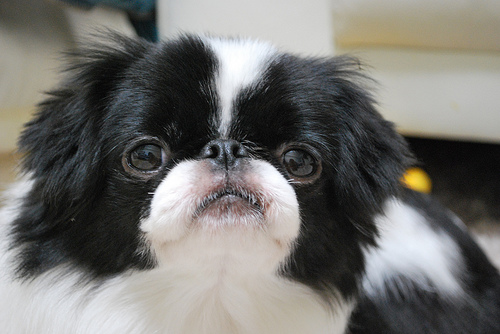

In [5]:
fname=(path/'images').ls()[0]
Image.open(fname)

In [6]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['japanese_chin']

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(seed=42),
get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

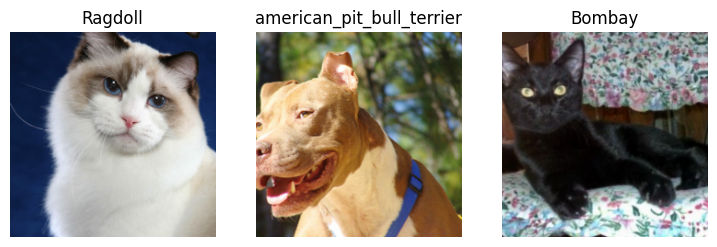

In [8]:
dls.show_batch(nrows=1,ncols=3)

In [9]:
learn=cnn_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.506987,0.329734,0.104195,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.502089,0.318590,0.096752,01:04
1,0.329064,0.239884,0.075101,01:05
